# Competição de Machine learning - Kaggle
### Alberto Oliveira Barbosa

# Objetivo:
## Prever a possibilidade de sobrevivência ao naufrágio do Titanic

## Bibliotecas e carga dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
dados = pd.read_csv('train.csv')
# Teste
teste = pd.read_csv('test.csv')
# Este será o dataframe resultante com a resposta
resposta = pd.DataFrame()

In [3]:
resposta['PassengerId'] = teste['PassengerId']

## Análise exploratória

Informações básicas sobre os dados, como nome das colunas, quantidade de observações em cada coluna e tipo de dados.

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Primeiros registros.
dados.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Últimos registros
dados.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Busca por valores inválidos
A existência de valores inválidos ou faltantes pode ocasionar em erros ou previsões erradas do modelo

In [7]:
# Busca por valores inválidos em todo o conjunto de dados
dados.isnull().values.any()

True

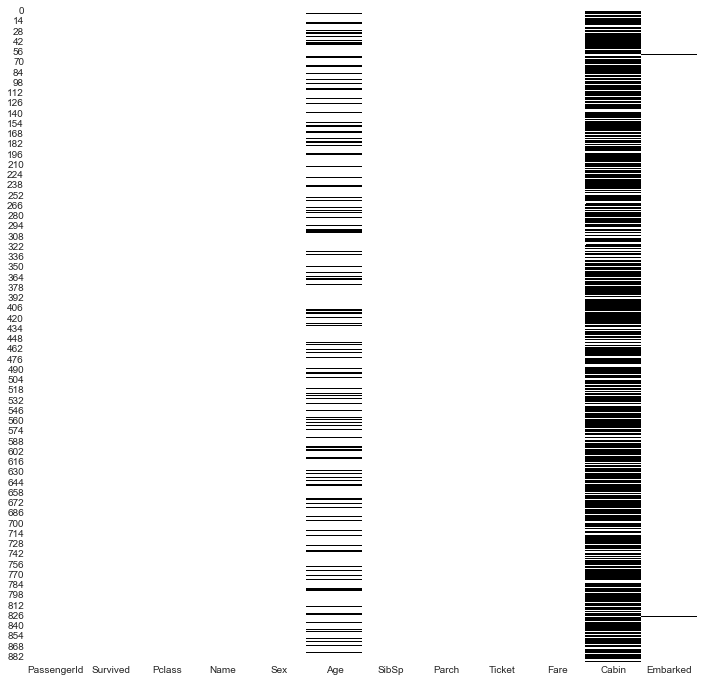

In [8]:
# VISUALIZAÇÃO EM GRÁFICO
# como o código anterior só retorna se existem ou não valores null, esta célula plota a posição deles em um gráfico
plt.figure(figsize=(12,12))
sns.set_style('whitegrid')
sns.heatmap(dados.isnull(), cbar=False, cmap='binary')

In [9]:
# Visualizar os nomes das colunas
dados.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Visualização dos dados com gráficos.

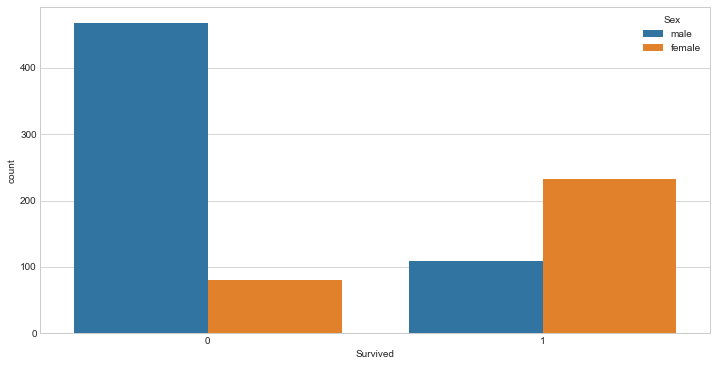

In [10]:
# DISTRIBUIÇÃO DE SOBREVIVENTES POR SEXO
plt.figure(figsize=(12,6))
sns.countplot(x='Survived', data=dados, hue='Sex')

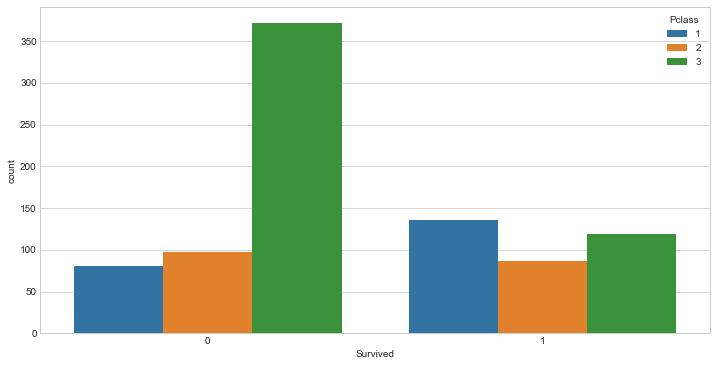

In [11]:
# DISTRIBUIÇÃO DE SOBREVIVENTES POR CLASSE
plt.figure(figsize=(12,6))
sns.countplot(x='Survived', data=dados, hue='Pclass')

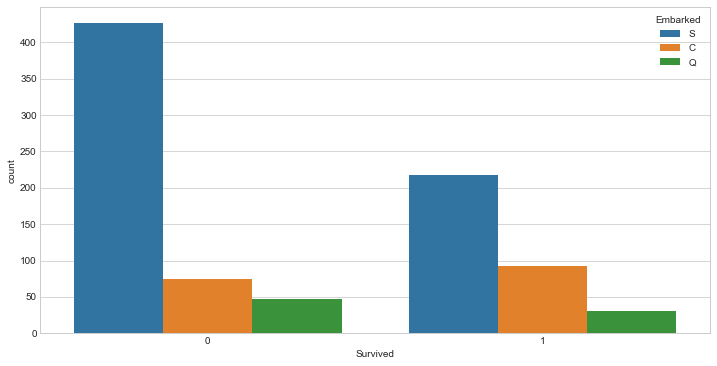

In [12]:
# DISTRIBUIÇÃO DE SOBREVIVENTES POR LOCALIDADE DE EMBARQUE
plt.figure(figsize=(12,6))
sns.countplot(x='Survived', data=dados, hue='Embarked')

In [13]:
# Contagem de passageiros por local de embarque
dados.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

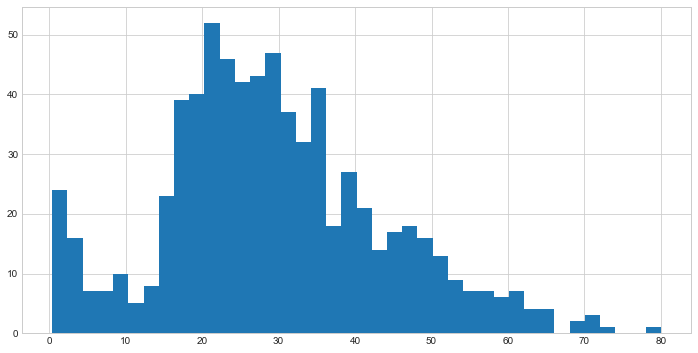

In [14]:
# DISTRIBUIÇÃO DE IDADES
plt.figure(figsize=(12,6))
dados.Age.hist(bins=40)

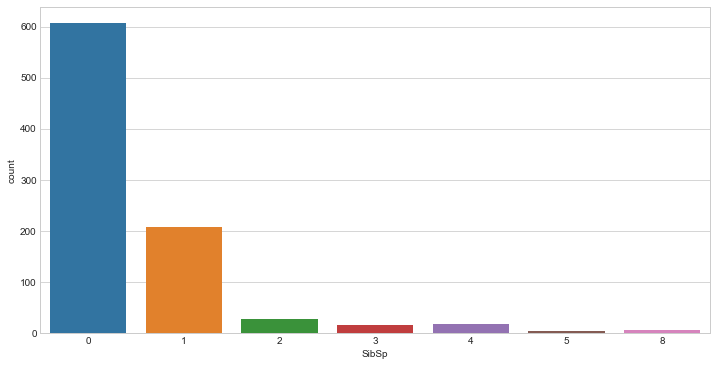

In [15]:
# DISTRIBUIÇÃO DE PASSAGEIROS COM ACOMPANHANTES
plt.figure(figsize=(12,6))
sns.countplot(x='SibSp', data=dados)

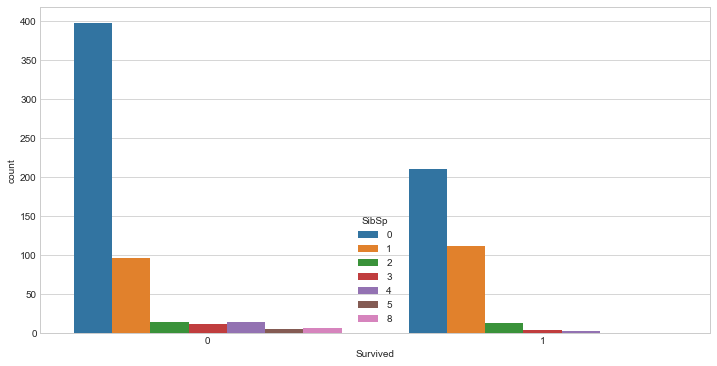

In [16]:
# DISTRIBUIÇÃO DE SOBREVIVENTES COM ACOMPANHANTES
plt.figure(figsize=(12,6))
sns.countplot(x='Survived', data=dados, hue='SibSp')

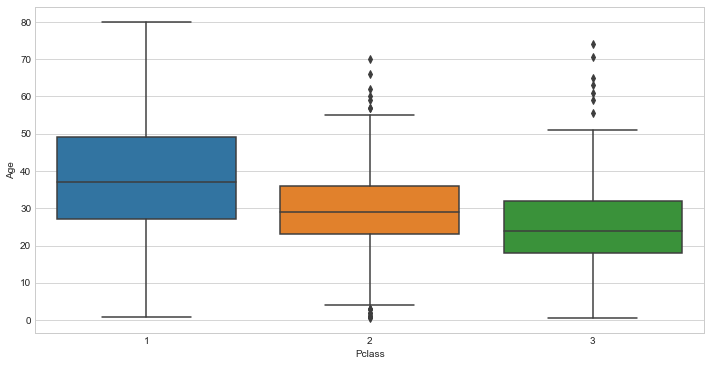

In [17]:
# VER A DISTRIBUIÇÃO DE IDADES POR CLASSE
plt.figure(figsize=(12,6))
sns.boxplot(x='Pclass', y='Age', data=dados,)

## Pré processamento
Como alguns algoritmos de machine learning só aceitam valores numéricos, é preciso fazer algum tipo de tratamento ou limpeza de dados antes de selecionar as features do modelo.

### Substituir os valores NaN da coluna Age por sua média.
Mesmo o boxplot anterior ter mostrado os valores aproximados das médias por classe, é necessário para a função a seguir um valor mais aproximado. 

In [18]:
# média da 1 classe.
dados.loc[dados.Pclass == 1,'Age'].mean()

38.233440860215055

In [19]:
# média da 2 classe.
dados.loc[dados.Pclass == 2,'Age'].mean()

29.87763005780347

In [20]:
# média da 3 classe.
dados.loc[dados.Pclass == 3,'Age'].mean()

25.14061971830986

In [21]:
# Função para aplicar a média para os dados NaN
def media(col):
    idade = col[0]
    classe = col[1]
    
    if(pd.isnull(idade)):
        if(classe == 1):
            return 38
        elif(classe == 2):
            return 30
        else:
            return 25
    else:
        return idade

In [22]:
# aplicação da função media em cada elemento da coluna age
dados['Age'] = dados[['Age','Pclass']].apply(media, axis=1)
teste['Age'] = teste[['Age','Pclass']].apply(media, axis=1)


In [23]:
# Visualização de como ficaram os dados.
dados.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


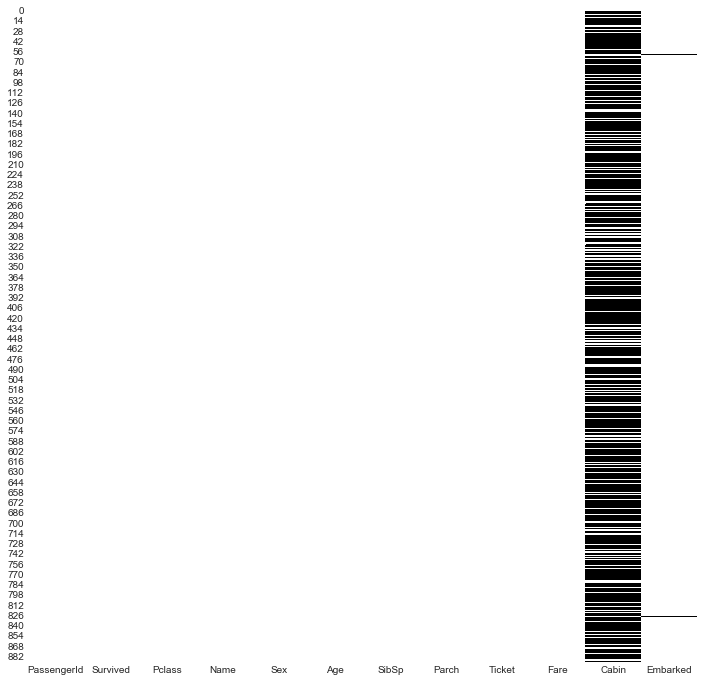

In [24]:
# Visualizar os valores NaN
plt.figure(figsize=(12,12))
sns.heatmap(dados.isnull(), cmap='binary', cbar=False)

### Transformação dos dados categóricos em discretos para a aplicação de algoritmos de machine learning  
Female = 0  
Male = 1

In [25]:
# conversão de dados categóricos em discretos
dados['Sex'] = dados['Sex'].map({'female':0,'male':1})
teste['Sex'] = teste['Sex'].map({'female':0,'male':1})

### Verificação da correlação dos atributos em busca de bons features

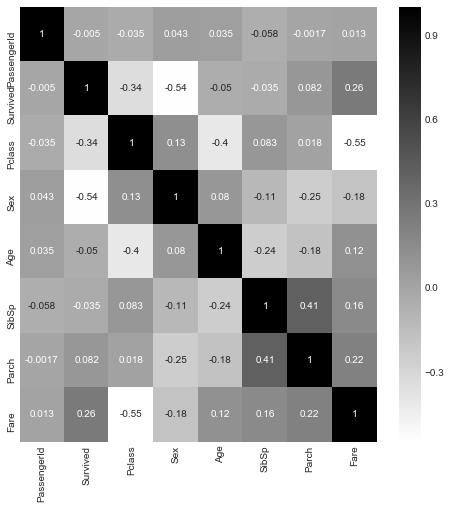

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(dados.corr(), cmap='binary', annot=True)

In [27]:
dados.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Definição das features: Pclass, Sex, Age, SibSp, Parch

Serão excluidas as colunas PassengerId, Name, Tiket, Fare, Embarked e Cabin, para não atrapalhar as predições

In [28]:
dados.drop(['PassengerId', 'Name','Ticket', 'Fare', 'Embarked', 'Cabin'], axis=1, inplace=True)
teste.drop(['PassengerId', 'Name','Ticket', 'Fare', 'Embarked', 'Cabin'], axis=1, inplace=True)

In [29]:
# Visualizar como estão os dados
dados.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


In [30]:
teste.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,34.5,0,0
1,3,0,47.0,1,0
2,2,1,62.0,0,0
3,3,1,27.0,0,0
4,3,0,22.0,1,1


# Preparação do modelo
## Separação das variáveis

In [31]:
previsores = dados.iloc[:, 1:].values
classe = dados.iloc[:, 0].values

In [32]:
previsores.shape

(891, 5)

In [33]:
teste.shape

(418, 5)

In [34]:
teste = teste.values

## Normalização

In [35]:
scaler = StandardScaler()

In [36]:
scaler.fit(previsores)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [37]:
previsores = scaler.fit_transform(previsores)

In [38]:
scaler.fit(teste)
teste = scaler.fit_transform(teste)

## Divisão em treino e teste

In [39]:
x_train, x_test,y_train, y_test = train_test_split(previsores, classe, test_size=0.3)

# Criação do modelo
## Logistic Regression

In [40]:
logistc_model = LogisticRegression()

In [41]:
logistc_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
logistic_predict = logistc_model.predict(x_test)

In [43]:
print(classification_report(y_test, logistic_predict))

             precision    recall  f1-score   support

          0       0.83      0.86      0.84       165
          1       0.76      0.71      0.73       103

avg / total       0.80      0.80      0.80       268



Distribuição dos valores obtidos:  
Com a confusion matrix é possivel ver a distribuição das classes pelo algoritmo, assim podemos realmente conferir se as previsões não estão tentando seguir algum tipo de tendência.

|Matriz de confusão ||
|-------------------- |--------------- |
|**verdadeiros positivos**|falsos positivos|
|falsos negativos|**verdadeiros negativos**|

In [44]:
print('MATRIZ DE CONFUSÃO\n',confusion_matrix(y_test, logistic_predict))

MATRIZ DE CONFUSÃO
 [[142  23]
 [ 30  73]]


## Naive Bayes

In [45]:
bayes_model = GaussianNB()

In [46]:
bayes_model.fit(x_train, y_train)

GaussianNB(priors=None)

In [47]:
bayes_predict = bayes_model.predict(x_test)

In [48]:
# Resumo dos resultados
print(classification_report(y_test, bayes_predict))

             precision    recall  f1-score   support

          0       0.86      0.74      0.79       165
          1       0.66      0.81      0.72       103

avg / total       0.78      0.76      0.77       268



In [49]:
# confusion matrix
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, bayes_predict))

MATRIZ DE CONFUSÃO
 [[122  43]
 [ 20  83]]


## Decision Tree

In [50]:
tree_model = DecisionTreeClassifier(criterion='entropy')

In [51]:
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
tree_predict = tree_model.predict(x_test)

In [53]:
print(classification_report(y_test,tree_predict))

             precision    recall  f1-score   support

          0       0.84      0.87      0.85       165
          1       0.78      0.73      0.75       103

avg / total       0.82      0.82      0.82       268



In [54]:
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, tree_predict))

MATRIZ DE CONFUSÃO
 [[144  21]
 [ 28  75]]


## Random Forest

In [55]:
forest_model = RandomForestClassifier(n_estimators=500)

In [56]:
forest_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
forest_predict = forest_model.predict(x_test)

In [58]:
print(classification_report(y_test, forest_predict))

             precision    recall  f1-score   support

          0       0.82      0.87      0.85       165
          1       0.77      0.70      0.73       103

avg / total       0.80      0.81      0.80       268



In [59]:
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, forest_predict))

MATRIZ DE CONFUSÃO
 [[144  21]
 [ 31  72]]


## KNN

In [60]:
# descobre a melhor número de n_neighbors a ser usado em um range de 1 a 100
taxa_erro = []
for i in range(1,101):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train, y_train)
    knn_predict = knn_model.predict(x_test)
    taxa_erro.append(np.mean(knn_predict!=y_test))

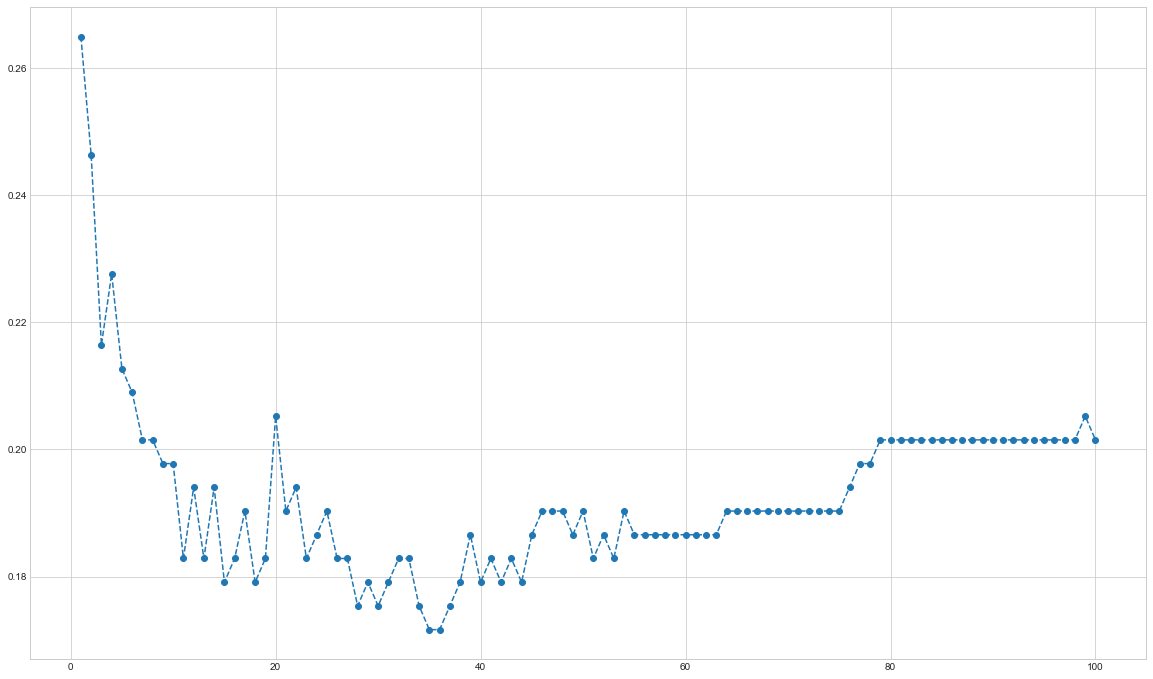

In [61]:
#plota a taxa de erro para uma melhor visualização
plt.figure(figsize=(20,12))
plt.plot(range(1,101), taxa_erro, linestyle='dashed', marker='o')

In [62]:
# busca o indice de menor taxa de erro para usar no algoritmo
menor = taxa_erro.index(min(taxa_erro)) + 1
print('Vizinho com a menor taxa de erro:', menor)

Vizinho com a menor taxa de erro: 35


In [63]:
# Criação do modelo com a taxa descoberta
knn_model = KNeighborsClassifier(n_neighbors=menor)

In [64]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=35, p=2,
           weights='uniform')

In [65]:
knn_predict = knn_model.predict(x_test)

In [66]:
print(classification_report(y_test, knn_predict))

             precision    recall  f1-score   support

          0       0.84      0.90      0.87       165
          1       0.81      0.72      0.76       103

avg / total       0.83      0.83      0.83       268



In [67]:
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, knn_predict))

MATRIZ DE CONFUSÃO
 [[148  17]
 [ 29  74]]


### SVM

In [68]:
svm_model = SVC()

In [69]:
svm_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
svm_predict = svm_model.predict(x_test)

In [71]:
print(classification_report(y_test, svm_predict))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       165
          1       0.83      0.69      0.75       103

avg / total       0.82      0.82      0.82       268



In [72]:
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, svm_predict))

MATRIZ DE CONFUSÃO
 [[150  15]
 [ 32  71]]


In [73]:
# ajustes
parametros = {'C': [0.1,1,10,100,1000,10000], 'gamma': [1,0.1,0.01,0.001,0.0001,0.00001], 'kernel': ['rbf']}

In [74]:
grid = GridSearchCV(SVC(), parametros, refit=True, verbose=3)

In [75]:
grid.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7644230769230769, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7644230769230769, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7777777777777778, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7932692307692307, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7836538461538461, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.8309178743961353, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...........................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, gamma=0.1, kernel=rbf, score=0.7980769230769231, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.8076923076923077, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.8357487922705314, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV]  C=1, gamma=0.01, kernel=rbf, score=0.7980769230769231, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV]  C=1, gamma=0.01, kernel=rbf, score=0.7692307692307693, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV]  C=1, gamma=0.01, kernel=rbf, score=0.8067632850241546, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV]  C=1, gamma=0.001, kernel=rbf, score=0.6153846153846154, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf .................

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   11.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [76]:
# Melhores parametros escolhidos
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [77]:
# predições com ajustes
svm_predict = grid.predict(x_test)

In [78]:
print(classification_report(y_test, svm_predict))

             precision    recall  f1-score   support

          0       0.83      0.90      0.86       165
          1       0.81      0.71      0.76       103

avg / total       0.82      0.82      0.82       268



In [79]:
print('MATRIZ DE CONFUSÃO\n', confusion_matrix(y_test, svm_predict))

MATRIZ DE CONFUSÃO
 [[148  17]
 [ 30  73]]


*OBS*: Para este caso o modelo sem ajustes atingiu um nível de acerto maior

# Resumo de resultados

In [87]:
print('Acurácia de %0.2f%% com Logistic Regression' % (accuracy_score(y_test,logistic_predict)*100))
print('Acurácia de %0.2f%% com Naive Bayes' % (accuracy_score(y_test,bayes_predict)*100))
print('Acurácia de %0.2f%% com Decision Tree' % (accuracy_score(y_test,tree_predict)*100))
print('Acurácia de %0.2f%% com Random Forest' % (accuracy_score(y_test,forest_predict)*100))
print('Acurácia de %0.2f%% com KNN' % (accuracy_score(y_test,knn_predict)*100))
print('Acurácia de %0.2f%% com SVM sem ajustes' % (accuracy_score(y_test,svm_predict)*100))

Acurácia de 81.34% com Logistic Regression
Acurácia de 80.60% com Naive Bayes
Acurácia de 82.09% com Decision Tree
Acurácia de 82.09% com Random Forest
Acurácia de 83.58% com KNN
Acurácia de 85.45% com SVM sem ajustes


# Dados de submissão

### Previsão dos valores

In [755]:
resposta['Survived'] = knn_model.predict(teste)

In [756]:
resposta.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


### Salva os dados

In [757]:
resposta.to_csv('prediction_titanic.csv', index=False)